In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import stats

Paramètres de l'étude:

In [2]:
# parameters of modelisation 
r = 0.03
sigma = 0.3
T = 1.0
K = 80
S0 = 100

# parameters for CEV modelization 
num_sim = 10000
dt = T/1000
beta = 1

Nous définissons également plusieurs fonctions utiles:

In [3]:
def BlackScholesPrice(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    return call_price

### Q1 - Pour un call européen standard, calculer l'écart entre le prix CEV (par Monte-Carlo) et le prix de Black-Scholes (théorique) en fonction de $S_0$ dans le cas $ \beta = 1 $ 

Nous définissons une fonction qui calcule le prix d'un call européen standard dans le cadre du modèle CEV

In [4]:
def CEVMontecarlo(r, delta, T, K, S0, beta, dt, num_sim):
    """ 
    The function computes CEV price of a european call 
    using euler schema. 

    :params r: float
    :params sigma: float
    :params T: float
    :params K: float
    :params S0: float
    :params dt: float
    :params num_sim: float
    :params beta: float
    """
    # initialization of assets prices
    S = np.zeros((num_sim, int(T/dt)+1), dtype=np.float64) 
    S[:, 0] = S0

    # comute step by step asset price
    for i in range(1, int(T/dt)+1):
        dW = np.random.normal(scale=np.sqrt(dt), size=num_sim)
        S[:, i] = S[:, i-1] + r * dt * S[:, i-1] + delta * (S[:, i-1] ** (beta/2)) * dW

    # Compute payoff
    payoff = np.maximum(S[:, -1] - K, np.zeros_like(S[:, -1], dtype=np.float64))

    # Commpute price using mean
    price = np.exp(-r * T) * np.nanmean(payoff)

    return price

In [5]:
def CEVExplicit(r, delta, T, K, S0, beta):
    """ 
    The function computes CEV price of a european call. 

    """
    # compute parameters
    k = 2*r / (delta**2 * (2-beta)*(np.exp(r*(2-beta)*T)-1))
    x = k * np.exp(r*(2-beta)*T) * S0**(2-beta)
    y = k * K**(2-beta) 

    # price = S0*stats.ncx2.sf(2*y,df= 2 + 2/(2-beta), nc=2*x) - K*(1 - stats.ncx2.sf(2*x, df=2/(2-beta), nc=2*y))
    price = S0*stats.ncx2.sf(2*y,df= 2 + 2/(2-beta), nc=2*x) - K*np.exp(-r*T)*stats.ncx2.cdf(2*x, df=2/(2-beta), nc=2*y)

    return price

On choisit ensuite $\delta$ de sorte que le prix explicite coincide avec le prix Black-Scholes à la monnaie: 

In [6]:
delta = sigma * K **.5  # 3.38
print(f"delta = {delta}\n")

monte_carlo = CEVMontecarlo(r, delta, T, K, K, beta, dt, num_sim)
explicit = CEVExplicit(r, delta, T, K, K, beta)
analytic = BlackScholesPrice(K, K, T, r, sigma)

print("à S0=K, ")
print(f"Monte carlo: {monte_carlo}")
print(f"Explicit: {explicit}")
print(f"Analytic: {analytic}")

delta = 2.6832815729997477



à S0=K, 
Monte carlo: 10.714338625329226
Explicit: 10.635301014688771
Analytic: 10.626646718304734


Notons qu'ici le prix obtenu par la méthode de Monte Carlo dans le modèle CEV est un peu optimiste.

Traçons désormais l'erreur entre les prix du modèle CEV explicite et Monte Carlo dans le modèle CEV et le prix du modèle de Black-Scholes.

In [7]:
# define S0 values for plotting results
S0_values = np.linspace(0.1*K, 2*K, num=100)

# compute prices using BS, CEV (explicit)
explicit = CEVExplicit(r, delta, T, K, S0_values, beta)
analytic = BlackScholesPrice(S0_values, K, T, r, sigma)

# compute monte carlo price
monte_carlo = np.zeros_like(explicit, dtype=np.float64)
for i, s in enumerate(S0_values):
    monte_carlo[i] = CEVMontecarlo(r, delta, T, K, s, beta, dt, num_sim)

# compute errors
error_explicit = np.abs(explicit - analytic) 
error_montecarlo = np.abs(monte_carlo - analytic) 

C:\Users\elkan\AppData\Local\Temp\ipykernel_15576\630965792.py:22: RuntimeWarning: invalid value encountered in sqrt
  S[:, i] = S[:, i-1] + r * dt * S[:, i-1] + delta * (S[:, i-1] ** (beta/2)) * dW


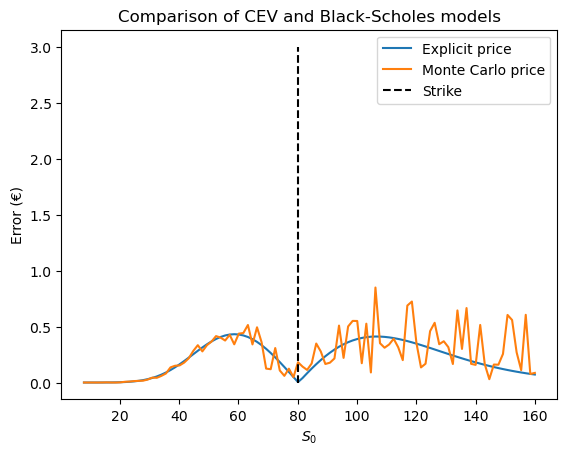

In [8]:
plt.plot(S0_values, error_explicit, label="Explicit price")
plt.plot(S0_values, error_montecarlo, label="Monte Carlo price")
plt.vlines(x=K, ymin=0, ymax=3., label="Strike",
           color="black", linestyle='--')

plt.title("Comparison of CEV and Black-Scholes models")
plt.xlabel("$S_0$")
plt.ylabel("Error (€)")

plt.legend()
plt.show()

Nous pouvons remarquer que le prix explicite et le prix de Monte Carlo ne coïncide pas. Cependant, plus $S_0$ est grand devant K, plus l'erreur est grande. En effet, la volatilité locale est d'autant plus conséquente quand le prix du sous-jacent grandit. Ainsi, le modèle de Black-Scholes devient d'autant plus faux. 

### Question 2 - Etudier la déformation du smile en fonction de $\beta$

In [9]:
def dichotomie(f, a, b, y, tol=1e-6, max_iter=100):
    """
    Résout l'équation f(x) = y par la méthode de la dichotomie.

    :param f: La fonction pour laquelle on veut trouver la solution.
    :param a: La borne inférieure de l'intervalle initial.
    :param b: La borne supérieure de l'intervalle initial.
    :param y: La valeur cible.
    :param tol: Tolérance pour la convergence (par défaut, 1e-6).
    :param max_iter: Nombre maximal d'itérations (par défaut, 100).
    :return: La valeur de x qui satisfait f(x) = y (ou None si la convergence n'est pas atteinte).
    """
    if abs(f(a) - y) < tol:
        return a
    if abs(f(b) - y) < tol:
        return b

    if (f(a)-y) * (f(b)-y) > 0:
        raise ValueError("Les valeurs de f(a) et f(b) doivent avoir des signes opposés.")

    for _ in range(max_iter):
        c = (a + b) / 2
        if abs(f(c) - y) < tol:
            return c
        elif f(c) > y:
            b = c
        else:
            a = c

    print("La méthode de la dichotomie n'a pas convergé après", max_iter, "itérations.")
    return None


In [10]:
beta_values = np.linspace(0.1, 1.9, 10) 
K_values = np.linspace(0.5*S0, 1.5*S0, 50)
smile = {}

for bet in beta_values:
    vol_implicite = []
    for k in K_values:

        f = lambda x: BlackScholesPrice(S0, k, T, r, x)
        y = CEVExplicit(r, delta, T, k, S0, bet)
        a, b = .0, 100.

        sigma = dichotomie(f, a, b, y=y, tol=1e-6, max_iter=10000)

        # print(f(a), f(b), y, f(sigma))

        vol_implicite.append(sigma)
    smile[bet] = vol_implicite    

C:\Users\elkan\AppData\Local\Temp\ipykernel_15576\1435400566.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


Text(0.5, 0.98, 'Volatility smile w.r.t. beta')

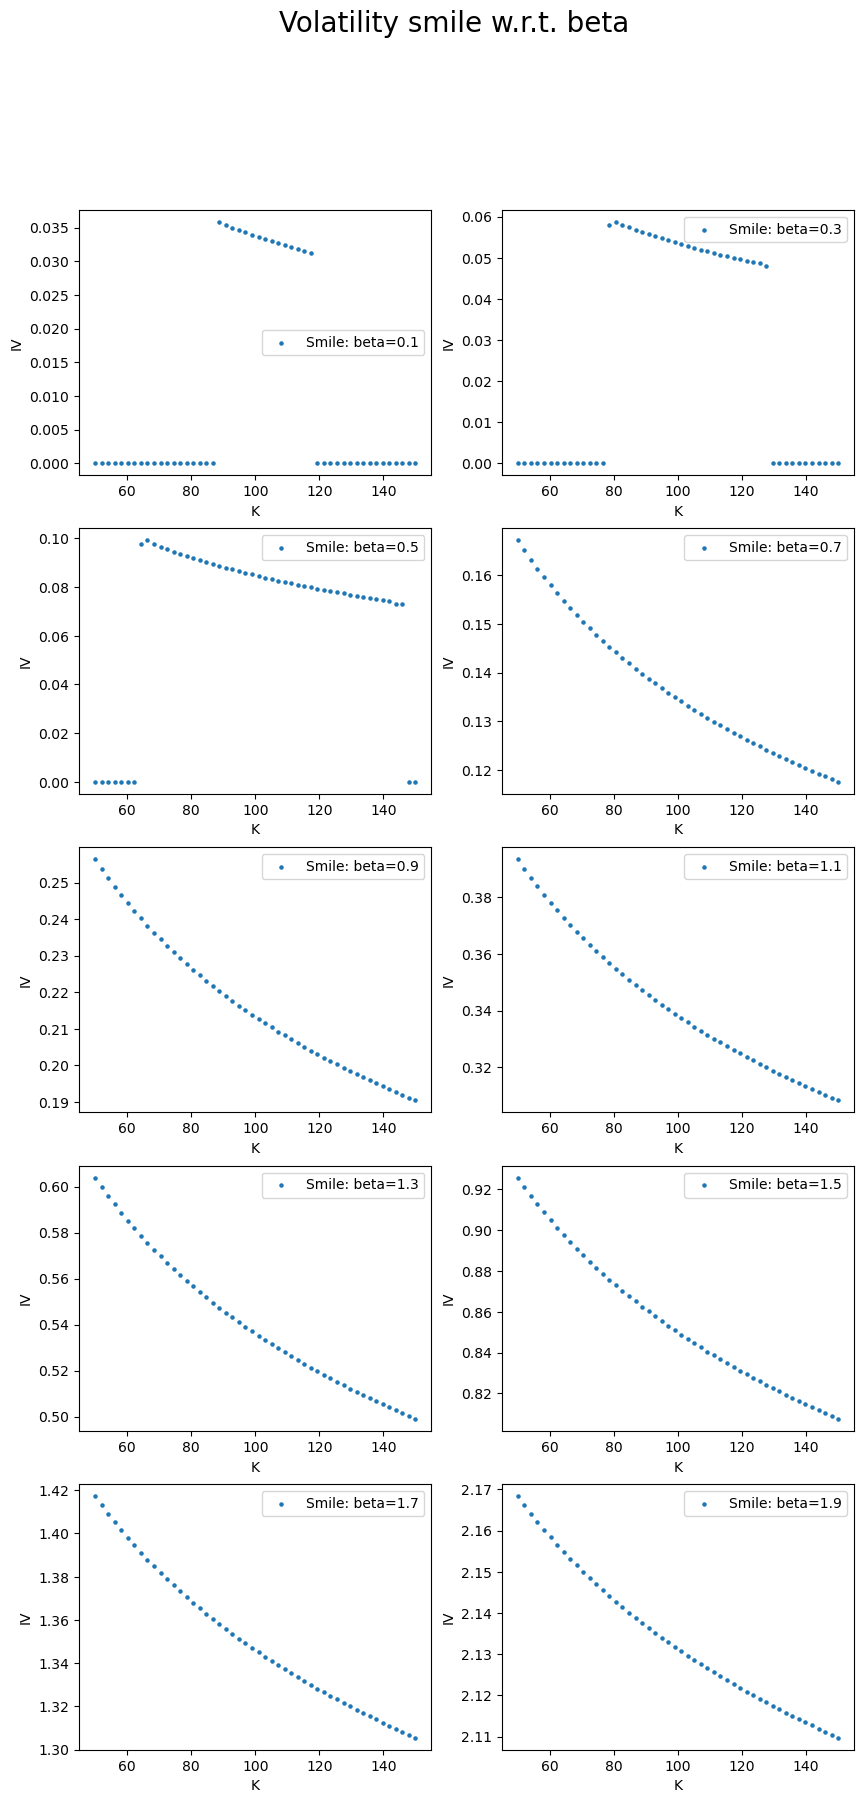

In [11]:
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

i = 0
for b, vol in smile.items():

    # index for plotting
    i_, j_ = i // 2, i%2

    # plot smile
    ax[i_, j_].scatter(K_values, vol, label=f"Smile: beta={round(b, 1)}", s=5.)
    ax[i_, j_].set_xlabel("K")
    ax[i_, j_].set_ylabel("IV")

    # add legend
    ax[i_, j_].legend()

    i += 1

fig.suptitle("Volatility smile w.r.t. beta", fontsize=20.)

Nous pouvons observer pour des valeurs de $\beta$ entre 0 et 2 que la volatilité tend à diminuer à mesure que le prix de l'actif augmente. Ainsi, nous pouvons donc observer qu'à $\beta$ fixé, nous avons à chaque fois une courbe décroissante. 

Cependant, nous observons que lorsque $\beta$ varie, le niveau change. (voir figure ajoutée ci-dessous) En effet, plus $\beta$ est grand, plus la volatilité est importante à strike fixé. Ainsi, il n'est pas surprenant de voir que le niveau augmente lorsque $\beta$ augmente. 

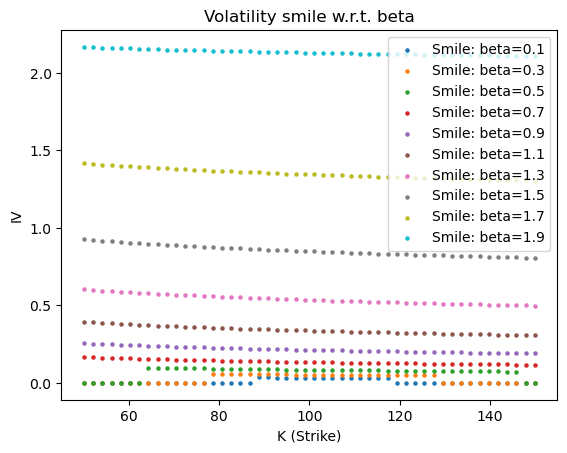

In [12]:
for b, vol in smile.items():
    # plot smile
    plt.scatter(K_values, vol, label=f"Smile: beta={round(b, 1)}", s=5.)

# add legend
plt.title('Volatility smile w.r.t. beta')
plt.xlabel("K (Strike)")
plt.ylabel("IV")
plt.legend()

### Question 3 - Cas $\beta$ > 2

D'après l'équation, le cas $\beta > 2$, signifie que la volatilité augmente avec le prix de l'actif. On peut donc le considérer comme une aversion au risque plus faible lorsque  les prix sont élevés.  

In [13]:
beta_values = [2.5]
K_values = np.linspace(0.5*S0, 1.5*S0, 10)

for bet in beta_values:
    vol_implicite = []
    print("Beta = ", bet, '\n')
    for k in K_values:

        f = lambda x: BlackScholesPrice(S0, k, T, r, x)
        y = CEVMontecarlo(r, delta, T, k, S0, bet, dt, num_sim=5000)
        a, b = .0, 1000.

        print("K:", k)
        print("f(0) =", f(a))
        print("f(infini) = ", f(b))
        print("Market price = ", y)
        print("\n")

Beta =  2.5 



C:\Users\elkan\AppData\Local\Temp\ipykernel_15576\630965792.py:22: RuntimeWarning: invalid value encountered in power
  S[:, i] = S[:, i-1] + r * dt * S[:, i-1] + delta * (S[:, i-1] ** (beta/2)) * dW


K: 50.0
f(0) = 51.47772332257459
f(infini) =  100.0
Market price =  0.04339740437509314




C:\Users\elkan\AppData\Local\Temp\ipykernel_15576\1435400566.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


K: 61.111111111111114
f(0) = 40.69499517203561
f(infini) =  100.0
Market price =  0.0023542672007140952


K: 72.22222222222223
f(0) = 29.912267021496632
f(infini) =  100.0
Market price =  0.0


K: 83.33333333333333
f(0) = 19.12953887095766
f(infini) =  100.0
Market price =  0.03799624878609536


K: 94.44444444444444
f(0) = 8.346810720418674
f(infini) =  100.0
Market price =  0.0


K: 105.55555555555556
f(0) = 0.0
f(infini) =  100.0
Market price =  0.0


K: 116.66666666666666
f(0) = 0.0
f(infini) =  100.0
Market price =  0.0005326287452404618


K: 127.77777777777777
f(0) = 0.0
f(infini) =  100.0
Market price =  0.06744360568666


K: 138.88888888888889
f(0) = 0.0
f(infini) =  100.0
Market price =  0.004559598047874968


K: 150.0
f(0) = 0.0
f(infini) =  100.0
Market price =  0.0


